In [34]:
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense,Dropout
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping,Callback

from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="tensorflow")
warnings.filterwarnings("ignore", category=FutureWarning, module="keras")



In [48]:
df = pd.read_csv('../dataset/tasks_dataset.csv') 
X = df.drop('DataCenterID', axis=1)  # Features
y = df['DataCenterID']-3  # Label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


unique_labels = np.unique(y_train.values)
num_classes = len(unique_labels)

In [50]:
if len(X_train.shape) < 3:
    X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

print(" xtrain ", X_train_re.shape, "\n", "ytrain ", y_train.shape, "\n", "xtest  ", X_test_re.shape, "\n", "ytest ", y_test.shape, "\n")



 xtrain  (800, 1, 5) 
 ytrain  (800,) 
 xtest   (200, 1, 5) 
 ytest  (200,) 



In [55]:
def trainModel(hyperparameters):
    # Build and train the model
    model = Sequential()
    model.add(LSTM(units=hyperparameters['units'], input_shape=(1, 5), return_sequences=True))
    model.add(Dropout(hyperparameters['dropout_rate']))
    model.add(LSTM(units=hyperparameters['units'] // 2))
    model.add(Dense(units=num_classes, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=hyperparameters['learning_rate']),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='accuracy', patience=20)
    history = model.fit(X_train, y_train,
                        epochs=120,
                        batch_size=hyperparameters['batch_size'],
                        validation_data=(X_test, y_test),
                        callbacks=[early_stopping])

hyperparameters = {'units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 32}
trainModel(hyperparameters)


Epoch 1/120
25/25 [==============================] - 5s 46ms/step - loss: 1.1034 - accuracy: 0.3187 - val_loss: 1.1027 - val_accuracy: 0.3400
Epoch 2/120
25/25 [==============================] - 0s 7ms/step - loss: 1.0895 - accuracy: 0.3825 - val_loss: 1.1033 - val_accuracy: 0.3450
Epoch 3/120
25/25 [==============================] - 0s 7ms/step - loss: 1.0840 - accuracy: 0.4075 - val_loss: 1.1089 - val_accuracy: 0.3300
Epoch 4/120
25/25 [==============================] - 0s 7ms/step - loss: 1.0745 - accuracy: 0.4375 - val_loss: 1.1088 - val_accuracy: 0.3500
Epoch 5/120
25/25 [==============================] - 0s 7ms/step - loss: 1.0708 - accuracy: 0.4450 - val_loss: 1.1129 - val_accuracy: 0.3150
Epoch 6/120
25/25 [==============================] - 0s 7ms/step - loss: 1.0628 - accuracy: 0.4525 - val_loss: 1.1170 - val_accuracy: 0.3100
Epoch 7/120
25/25 [==============================] - 0s 7ms/step - loss: 1.0578 - accuracy: 0.4550 - val_loss: 1.1169 - val_accuracy: 0.3100
Epoch 8/120


7/7 [==============================] - 0s 6ms/step - loss: 1.1081 - accuracy: 0.3500
 Loss: 108 %
 accuracy: 38 %
Validation loss: 110 %
validation accuracy: 34 %
7/7 [==============================] - 1s 2ms/step


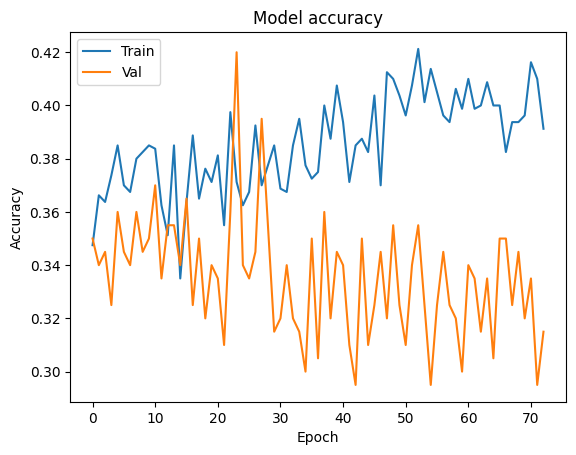

In [56]:
val_loss, val_accuracy = model.evaluate(X_test_re, y_test)
accuracy=np.mean(history.history['accuracy'])
loss=np.mean(history.history['loss'])


print(' Loss:', int(loss*100),"%")
print(' accuracy:', int(accuracy*100),"%")
print('Validation loss:', int(val_loss*100),"%")
print('validation accuracy:', int(val_accuracy*100),"%")

###################33
predictions = model.predict(X_test_re)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = y_test.values

worng_classes = np.where(predicted_classes != true_classes)[0]
correct_classes = np.where(predicted_classes == true_classes)[0]
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

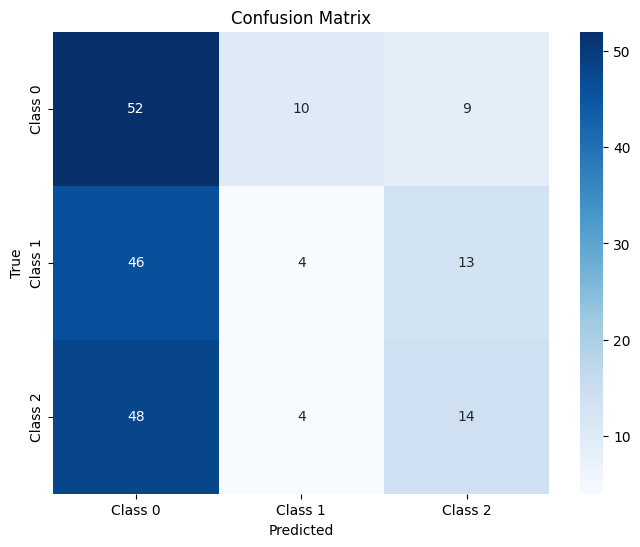

In [57]:
#Confusin matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming you have already defined predicted_classes, true_classes, worng_classes, and correct_classes

# Create a confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1", "Class 2"], yticklabels=["Class 0", "Class 1", "Class 2"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [8]:

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, mean_squared_error

y_true = y_test  # True categorical labels
y_pred = model.predict(X_test)  # Predicted categorical labels
print(y_true[:10])
print(y_pred[0])
# accuracy = accuracy_score(y_true, y_pred)
# mse = mean_squared_error(y_true, y_pred)  # Note: Use with caution for categorical data
# confusion_matrix = confusion_matrix(y_true, y_pred)
# f1_score = f1_score(y_true, y_pred, average='weighted')  # Or specify a particular class

# model.save('models\lstm87.keras')

ValueError: in user code:

    File "C:\Users\mohsal\Desktop\app\metalux\cloudsim\ga_lstm\AI_code\.venv10\lib\site-packages\keras\src\engine\training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\mohsal\Desktop\app\metalux\cloudsim\ga_lstm\AI_code\.venv10\lib\site-packages\keras\src\engine\training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\mohsal\Desktop\app\metalux\cloudsim\ga_lstm\AI_code\.venv10\lib\site-packages\keras\src\engine\training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\mohsal\Desktop\app\metalux\cloudsim\ga_lstm\AI_code\.venv10\lib\site-packages\keras\src\engine\training.py", line 2381, in predict_step
        return self(x, training=False)
    File "C:\Users\mohsal\Desktop\app\metalux\cloudsim\ga_lstm\AI_code\.venv10\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\mohsal\Desktop\app\metalux\cloudsim\ga_lstm\AI_code\.venv10\lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 1, 5), found shape=(None, 5)


In [ ]:
def predict_datacenter_id(requested_array,model_name):
    data_dict = {
        "TaskID": requested_array[0],
        "TaskFileSize": requested_array[1],
        "TaskOutputFileSize": requested_array[2],
        "TaskFileLength": requested_array[3],

    }
    input_data = np.array([[
        data_dict["TaskID"],
        data_dict["TaskFileSize"],
        data_dict["TaskOutputFileSize"],
        data_dict["TaskFileLength"]]])
    # Load the saved model
    loaded_model = load_model(model_name)
    # Reshape the input data to match the LSTM input shape
    input_data_lstm = input_data.reshape(input_data.shape[0], 1, input_data.shape[1])
    # Make predictions using the loaded model
    predicted_probabilities = loaded_model.predict(input_data_lstm)
    predicted_class = np.argmax(predicted_probabilities, axis=1)
    predicted_DC=predicted_class[0]
    return predicted_DC
requested_array = [0.1, 0, 0, 55]
predicted_datacenter_id = predict_datacenter_id(requested_array,"models\lstm87.keras")
print(f"Predicted DataCenterID: {predicted_datacenter_id}")


In [ ]:
# Define the LSTM model
def create_and_train_model(units1, units2, dropout_rate, learning_rate, epochs, batch_size):
    print("\n\nNew generation training start. Parameters:")
    print(f"Units1: {units1}, Units2: {units2}, Dropout Rate: {dropout_rate}, Learning Rate: {learning_rate}, Epochs: {epochs}, Batch Size: {batch_size}\n")
    model = Sequential()
    model.add(LSTM(units=int(units1), input_shape=(1, X_train.shape[1]), return_sequences=True))
    model.add(LSTM(units=int(units2)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=len(df['DataCenterID'].unique()), activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    early_stopping = EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True)
    history = model.fit(X_train_lstm, y_train, epochs=int(epochs), batch_size=int(batch_size), validation_data=(X_val_lstm, y_val), callbacks=[early_stopping])
    # Return the validation accuracy as the fitness
    return history.history['accuracy'][-1]

# Define individual
indv_template = BinaryIndividual(ranges=[(10, 100), (10, 100), (0.0, 1.0), (0.001, 0.1), (10, 100), (10, 100)])

# Create population
population = Population(indv_template=indv_template, size=50).init()

# Define Genetic Algorithm operators
selection = RouletteWheelSelection()
crossover = UniformCrossover(pc=0.8, pe=0.5)
mutation = FlipBitMutation(pm=0.1)

# Create Genetic Algorithm engine
engine = GAEngine(population=population, selection=selection, crossover=crossover, mutation=mutation)

# Define and register fitness function
@engine.fitness_register
def fitness(indv):
    # Decode GA individual to LSTM parameters
    units1, units2, dropout_rate, learning_rate, epochs, batch_size = indv.solution

    # Create and train LSTM model
    val_accuracy = create_and_train_model(units1, units2, dropout_rate, learning_rate, epochs, batch_size)
    
    return val_accuracy

# Run the Genetic Algorithm
engine.run(ng=50)


In [ ]:
!pip install ipynb-py-convert


In [ ]:
pwd


In [ ]:

pip freeze